In [4]:

!pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas kubernetes openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.2/209.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.7/320.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 77.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 78.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.6/411.6 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.

In [17]:
import os
import getpass

In [26]:

# 定义函数，设置未定义的环境变量
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

# 设置 OPENAI API 密钥
_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("TAVILY_API_KEY")



Please provide your TAVILY_API_KEY··········


## 定义管理者

In [14]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal,Sequence
from typing import Annotated
import operator
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

In [40]:
# members = ["Researcher", "Coder", "AutoFixk8s", "humanHelp"]
members = ["Researcher", "Coder", "HumanHelp"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
options = ["FINISH"] + members

class routeResponse(BaseModel):
  next: Literal[options]



prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name = "messages"),
        (
            "system",
            "iven the conversation above, who should act next?"
            "Or should we FINISH Select one of: {options}",
        ),
    ]
).partial(members=",".join(members), options=str(options))

class AgentState(TypedDict):
  messages: Annotated[Sequence[BaseMessage], operator.add]
  next: str



llm = ChatOpenAI(model="gpt-4o")
def supervisor_agent(state):
    supervisor_chain = prompt | llm.with_structured_output(routeResponse)
    return supervisor_chain.invoke(state)

In [32]:
# 定义 K8s 自动修复工具
# 这里定义一个 K8s 自动修复工具，使用 OPENAI 模型生成 patch json
from langchain_core.tools import tool
from openai import OpenAI
from kubernetes import client, config, watch
import yaml

config.load_kube_config()
k8s_apps_v1 = client.AppsV1Api()

@tool
def auto_fix_k8s(deployment_name, namespace, event: str):
    """自动修复 K8s 问题"""
    # 先根据 deployment_name 去获取 Deployment YAML
    deployment = k8s_apps_v1.read_namespaced_deployment(
        name=deployment_name, namespace=namespace
    )
    deployment_dict = deployment.to_dict()
    # 移除不必要的字段
    deployment_dict.pop("status", None)
    if "metadata" in deployment_dict:
        deployment_dict["metadata"].pop("managed_fields", None)

    # 请求 OpenAI 生成修复的 Patch JSON
    deployment_yaml = yaml.dump(deployment_dict)
    OpenAIClient = OpenAI()
    response = OpenAIClient.chat.completions.create(
        model="gpt-4o",
        response_format={"type":"json_object"},
        messages=[
            {
                "role": "system",
                "content": "你是一个助理用来输出 JSON"
            },
            {
                "role": "user",
                "content": f"""你现在是一个云原生技术专家，现在你需要根据 K8s 的报错生成一个能通过 kubectl patch 的一段 JSON 内容来修复问题。
        K8s 抛出的错误信息是：{event}
        工作负载的 YAML 是：
        {deployment_yaml}
    你生成的 patch JSON 应该可以直接通过 kubectl patch 命令使用，除此之外不要提供其他无用的建议，直接返回 JSON，且不要把 JSON 放在代码块内
    """,
            }
        ]
    )

    json_opt = response.choices[0].message.content
    print(json_opt)

    # Apply Patch JSON
    try:
        k8s_apps_v1.patch_namespaced_deployment(
            name=deployment_name,
            namespace=namespace,
            body=yaml.safe_load(json_opt)
        )
    except Exception as e:
        print(f"修复失败：{str(e)}")
        return f"修复失败：{str(e)}"

    return f"工作自动修复成功！"

ConfigException: Invalid kube-config file. No configuration found.

In [38]:

# 定义人工帮助的 Tool
# 用于在无法自动修复的时候发送飞书消息通知

import requests
import json

@tool
def human_help(event_message: str):
    """无法修复问题时寻求人工帮助"""
    url = "https://open.feishu.cn/open-apis/bot/v2/hook/d5e267dc-a92f-43d3-bc45-106b5e718c49"
    headers = {"Content-Type": "application/json"}
    data = {"msg_type": "text", "content": {"text": event_message}}
    response = requests.post(url, headers=headers, data=json.dumps(data))
    return "寻求人类帮助成功，结束任务"

In [29]:
# 定义消息 Agent 的节点
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name ):
  result = agent.invoke(state)
  return {
      "messages":[HumanMessage(content=result)],
      "name":name,
      "state":result
  }

In [27]:

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

# 初始化两个工具
tavily_tool = TavilySearchResults(max_results=5)
# 执行 Python 代码的工具，谨慎使用
python_repl_tool = PythonREPLTool()

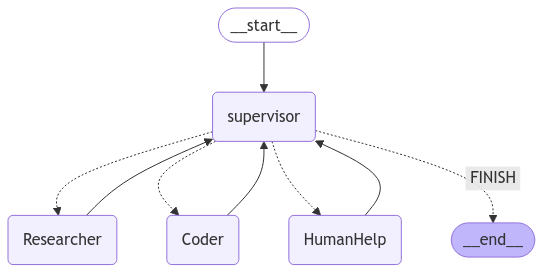

In [41]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent
import functools

# 创建 research agent
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# code agent
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")

# auto fix agent
# auto_fix_agent = create_react_agent(llm, tools=[auto_fix_k8s])
# auto_fix_node = functools.partial(agent_node, agent=auto_fix_agent, name="AutoFixK8s")

# human help agent
human_help_agent = create_react_agent(llm, tools=[human_help])
human_help_node = functools.partial(agent_node, agent=human_help_agent, name="HumanHelp")

# 创建 Graph 并且添加节点
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", research_node)
workflow.add_node("supervisor", supervisor_agent)
# workflow.add_node("AutoFixK8s", auto_fix_node)
workflow.add_node("HumanHelp", human_help_node)

# 定义路由逻辑
for member in members:
    workflow.add_edge(member, "supervisor")

conditional_map = {k:k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

workflow.add_edge(START, "supervisor")

# 编译 Graph
graph = workflow.compile()

# 展示 Graph
from IPython.display import display, Image
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

In [42]:

config.load_kube_config()
k8s_apps_v1 = client.AppsV1Api()
core_v1 = client.CoreV1Api()

w = watch.Watch()

def run_stream(message: str):
    for s in graph.stream(
        {
            "messages": [
                HumanMessage(content=message)
            ]
        }
    ):
        if "__end__" not in s:
            print(s)
            print("----")




ConfigException: Invalid kube-config file. No configuration found.

In [ ]:
try:
    namespace = "default"
    for event in w.stream(
        core_v1.list_namespaced_event, namespace=namespace, _request_timeout=None
    ):
        event_type = event["type"]
        event_object = event["object"]

        # 检查事件类型
        if event_object.type == "Warning":
            involved_object = event_object.involved_object
            pod_name = involved_object.name
            reason = event_object.reason
            message = event_object.message

            print(f"Warning Event: {event_type} {pod_name} - {reason} - {message}")

            # 处理异常：Pod 可能不存在
            try:
                pod = core_v1.read_namespaced_pod(name=pod_name, namespace=namespace)
                deployment_name = pod.metadata.labels.get("app","unknown")
            except client.exceptions.ApiException as e:
                print(f"Error reading Pod {pod_name}: {e}")
                continue

            # 传递 Warning 事件到 run_stream()
            try:
                run_stream(f"deployment: {deployment_name}, namespace: {namespace}, event: {reason} - {message}")
                time.sleep(10)
            except Exception as e:
                print(e)
                continue
        else:
            print(f"Ignore non-warning event: {event_object.type} {event_object.reason} - {event_object.message}")

finally:
    w.stop()